In [4]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as stats

In [5]:
def smooth_timeseries(t, size=5, axis=0):
    '''Smooth the function by taking a moving average of "size" time steps'''
    average_filter = np.full((size, ), 1 / size)

    t = np.pad(t, [(size // 2 + (not size % 2), size // 2)], mode='median', stat_length=size)
    return np.apply_along_axis(lambda r: np.convolve(r, average_filter, mode='valid'), 
        axis=axis, arr=t)

In [6]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases_all = datadict['cases_raw']
deaths_all = datadict['deaths_raw']

In [7]:
demographics = u.load_demographics_data()
pop = demographics['total_pop']

In [196]:
county = 1293
cases_raw = cases_all[county] 
deaths_raw = deaths_all[county]

b = deaths_raw != 0
deaths_raw = deaths_raw[b]
cases_raw = cases_raw[b]

cases = np.diff(cases_raw)
deaths = np.diff(deaths_raw)

s = 7
cases_smooth = smooth_timeseries(cases, s)
deaths_smooth = smooth_timeseries(deaths, s)

z = deaths_smooth

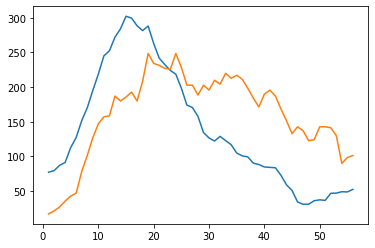

In [197]:
y = cases_smooth
x = np.arange(1, y.shape[0] + 1)
plt.plot(x, y)

y = deaths_smooth * 10
x = np.linspace(1, y.shape[0], y.shape[0])
plt.plot(x, y)

# Least Squares fit model

In [198]:
dat = z

validation_steps = 10

X_train = np.arange(dat.shape[0] - validation_steps)
y_train = dat[:dat.shape[0] - validation_steps]

X_test = np.arange(dat.shape[0] - validation_steps, dat.shape[0])
y_test = dat[dat.shape[0] - validation_steps:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(46,) (46,) (10,) (10,)


In [199]:
def erf_model(x, max_val, loc, scale):
    return max_val*(1 + scipy.special.erf(scale*(x - loc)))

def skew_model(x, max_val, loc, scale, a, shift):
    return max_val * stats.skewnorm.pdf(x, a, loc, scale) + shift

def exp_model(x, max_val, loc, scale, K):
    return max_val*stats.exponnorm.pdf(x, K, loc, scale)

def bimodal_exp_model(x, max_val1, loc1, scale1, K1, max_val2, loc2, scale2, K2):
    return exp_model(x, max_val1, loc1, scale1, K1) + exp_model(x, max_val2, loc2, scale2, K2)

def exp_modelcdf(x, max_val, loc, scale, K):
    return max_val*stats.exponnorm.cdf(x, K, loc, scale)

erf_bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
exp_bounds = ([z.max(), 0, 0, 0], [100*z.max(), np.inf, np.inf, 15])
bimodal_bounds = ([z.max(), 0, 0, 0, z.max(), 30, 10, 0], [100*z.max(), np.inf, np.inf, 15, 65*z.max(), np.inf, np.inf, 15])

model = exp_model
bounds = exp_bounds
popt, pcov = curve_fit(model, X_train, y_train, bounds=bounds)

In [200]:
print(popt)

[1834.32285015    9.21400436    6.18450242   10.53018642]


In [201]:
errors = np.sqrt(np.diag(pcov))
print(errors)

[205.6780632    0.46671687   0.54238816   2.37292712]


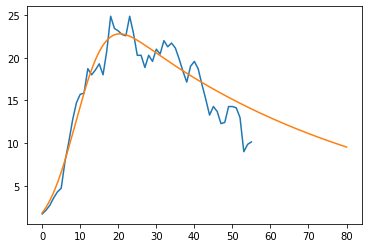

In [202]:
d = deaths_smooth
x = np.linspace(0, d.shape[0] - 1, d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(0, 80, 1000)
y = model(x, *popt)

# xx = np.linspace(0, d.shape[0] + 20, d.shape[0] + 21)
# x = np.arange(0, d.shape[0] + 20)
# y = model(xx, *popt)
# y = np.diff(y)

plt.plot(x, y)
#plt.plot(X_train, y_train, marker='o', linewidth=0)
#plt.plot(X_test, y_test, marker='o', linewidth=0)

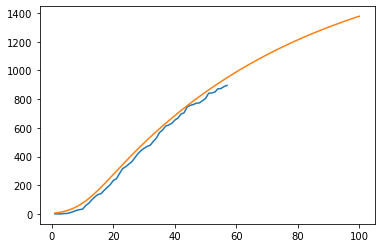

In [203]:
d = deaths_raw
x = np.linspace(1, d.shape[0], d.shape[0])
y = d
plt.plot(x, y)

x = np.linspace(1, 100, 1000)
y = exp_modelcdf(x, *popt)
plt.plot(x, y)

# GP for cases -> deaths model

In [204]:
delays = np.arange(1, 15)
corr = []
for delay in delays:
    cases_past = []
    deaths_curr = []
    for i in range(delay, cases_smooth.shape[0]):
        if i < 0.25 * cases_smooth.shape[0]:
            continue
        cases_past.append(cases_smooth[i - delay])
        deaths_curr.append(deaths_smooth[i])
    co = np.corrcoef(cases_past, deaths_curr)[0, 1]
    corr.append(co)

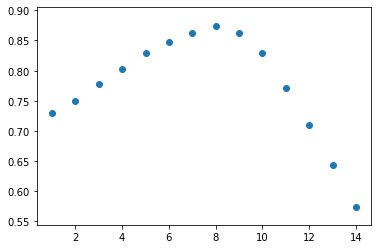

In [205]:
plt.scatter(delays, corr)

In [206]:
best_delays = np.argsort(corr)[::-1] + 1
best_delay = best_delays[best_delays > 5][0]
print(best_delay)

8


In [207]:
delay = best_delay
colors = []
cases_past = []
deaths_curr = []
rate = []
for i in range(delay + 1, cases_smooth.shape[0]):
    if i < 0.25 * cases_smooth.shape[0]:
            continue
    cases_past.append(cases_smooth[i - delay])
    deaths_curr.append(deaths_smooth[i])
    rate.append(deaths_smooth[i] / cases_smooth[i - delay])
    colors.append(i)

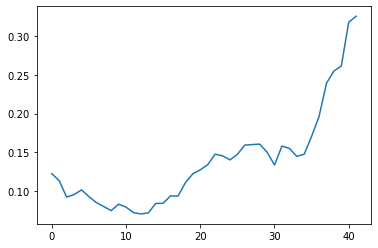

In [208]:
y = rate
x = np.arange(0, len(rate))
plt.plot(x, y)

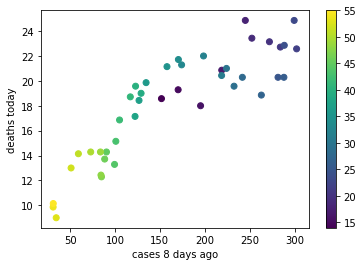

In [209]:
plt.scatter(cases_past, deaths_curr, c=colors)
plt.xlabel(f'cases {delay} days ago')
plt.ylabel('deaths today')
plt.colorbar()
plt.show()

In [210]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [211]:
scale_factor = np.max(cases_past) / 100
deaths_curr2 = np.array(deaths_curr) / scale_factor
cases_past2 = np.array(cases_past) / scale_factor

with pm.Model() as gp_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=(deaths_curr2/cases_past2).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
#     Xu = pm.gp.util.kmeans_inducing_points(20, cases_past.reshape(-1,1))
    
    deaths_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    deaths_gp.marginal_likelihood('deaths', X=cases_past2.reshape(-1,1),
                           y=deaths_curr2, noise=σ)
    

In [212]:
with gp_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains, 0 divergences: 100%|███████████████████████████████████████████████████| 6000/6000 [00:19<00:00, 311.61draws/s]


In [213]:
X_pred = np.arange(0, np.max(cases_past2)*2)
with gp_model:
    deaths_pred = deaths_gp.conditional("deaths_pred_noise", X_pred.reshape(-1, 1), pred_noise=True)
    gp_samples = pm.sample_posterior_predictive(gp_trace, vars=[deaths_pred], samples=500, random_seed=42)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 26.28it/s]


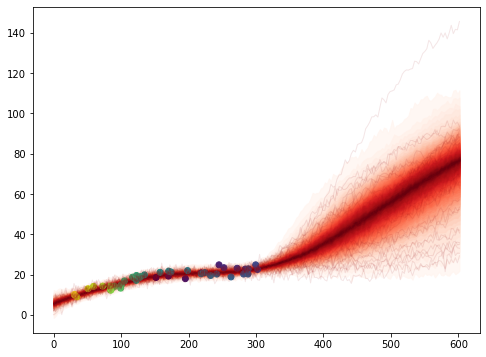

In [214]:
from pymc3.gp.util import plot_gp_dist

fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_samples['deaths_pred_noise'] * scale_factor, X_pred * scale_factor)

cases_past3 = cases_past2 * scale_factor
deaths_curr3 = deaths_curr2 * scale_factor

ax.scatter(cases_past3, deaths_curr3, c=colors)
# ax.xlabel(f'cases {delay} days ago')
# ax.ylabel('deaths today')

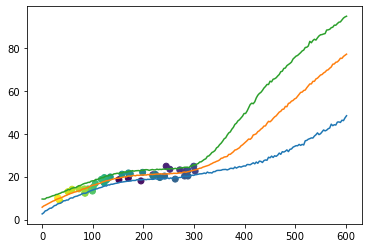

In [215]:
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]
quantile_gp = [np.percentile(gp_samples['deaths_pred_noise'] * scale_factor, q, axis=0)  for q in percentiles]

X_pred2 = X_pred * scale_factor
plt.plot(X_pred2, quantile_gp[0])
plt.plot(X_pred2, quantile_gp[4])
plt.plot(X_pred2, quantile_gp[8])
plt.scatter(cases_past3, deaths_curr3, c=colors)

# GP on deaths directly

In [34]:
import theano.tensor as tt

class ExpModel(pm.gp.mean.Mean):

    def __init__(self, max_val, loc, scale, K):
        pm.gp.mean.Mean.__init__(self)
        self.max_val = max_val
        self.loc = loc
        self.scale = scale
        self.K = K

    def __call__(self, X):
        return self.max_val*stats.exponnorm.pdf(X[0], self.K, self.loc, self.scale)

In [370]:
with pm.Model() as gp_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = ExpModel(*popt)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    expnorm_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    expnorm_gp.marginal_likelihood('expnorm', X=X_train.reshape(-1,1), 
                           y=y_train, noise=σ)

In [371]:
with gp_model:
    expnorm_gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains, 0 divergences: 100%|███████████████████████████████████████████████████| 6000/6000 [00:17<00:00, 336.76draws/s]


In [307]:
X_pred = np.arange(0, np.max(X_train) + 30)
with gp_model:
    expnorm_deaths_pred = expnorm_gp.conditional("expnorm_deaths_pred", X_pred.reshape(-1, 1), pred_noise=True)
    gp_samples = pm.sample_posterior_predictive(expnorm_gp_trace, vars=[expnorm_deaths_pred], samples=500, random_seed=42)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 95.64it/s]


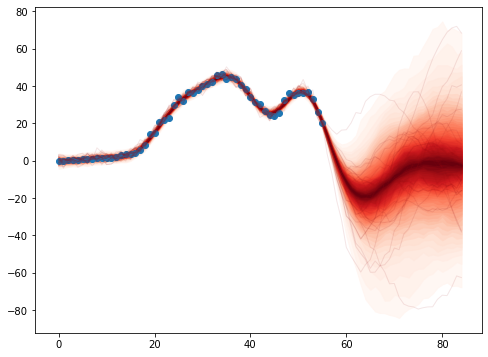

In [308]:
from pymc3.gp.util import plot_gp_dist

fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_samples['expnorm_deaths_pred'], X_pred)

ax.scatter(X_train, y_train)

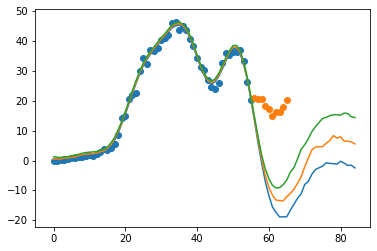

In [309]:
percentiles = [p for p in range(50, 80, 3)]
quantile_gp = [np.percentile(gp_samples['expnorm_deaths_pred'], q, axis=0) for q in percentiles]

plt.plot(X_pred, quantile_gp[0])
plt.plot(X_pred, quantile_gp[4])
plt.plot(X_pred, quantile_gp[8])
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

# plt.xlim(50, 70)
# plt.ylim(-50, 250)

# GP on simulated data from curve fit

In [27]:
d = deaths
x = np.linspace(1, d.shape[0], d.shape[0])
y = model(x, *popt)

residuals = (d - y)[:-validation_steps]
print(residuals)

[ 3.58725497e+00  1.18525758e+00  2.44671358e+00  1.11394351e+01
  9.10133105e-01  1.42479261e+01  6.45301885e+00  2.06216899e+01
 -3.38610514e-01  2.03496288e+01  2.04458384e+01 -7.14424489e+00
 -2.81659490e+01  6.21957365e+01 -9.45050976e+01 -1.13874442e+02
 -1.20692835e+02 -9.10627366e+01 -2.28678525e+02 -1.00179956e+02
 -7.85285881e+01 -2.71339551e+02  4.81889414e+02  2.46861548e+01
  5.26535720e+01  5.36356135e+01 -1.00445295e+01  3.06750389e+01
  1.68305959e+01 -2.03859012e+01  1.23487068e+02  1.03229653e+02
 -3.10619435e+01 -3.69011967e+02 -3.85018287e+02  7.36691293e+02
 -1.49916752e+01  7.90276903e+00  3.93926823e+01  1.85233545e+01
  3.13538784e+01  5.09490328e+01  1.83746814e+01  3.16953436e+01
  9.89730247e+01  1.21266735e+02 -4.23676402e+01 -1.17877297e+02
 -1.36212400e+02  2.16674064e+02 -7.21735634e+01 -5.07134650e+01]


In [28]:
s = np.std(residuals)
m = np.mean(residuals)
s, m

(164.55058159401818, 0.7326422113222708)

In [29]:
X_train2 = np.linspace(X_train[0], X_train[-1] + 25, 100)

In [30]:
noise = np.random.normal(loc=m, scale=s, size=X_train2.shape)
y_train2 = model(X_train2, *popt) + noise
y_train2[y_train2 < 0] = 0

In [31]:
print(X_train2.shape, y_train2.shape)

(100,) (100,)


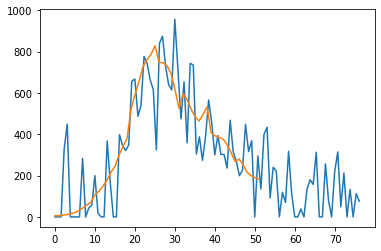

In [32]:
plt.plot(X_train2, y_train2)
plt.plot(X_train, y_train)

In [41]:
with pm.Model() as gp_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = ExpModel(*popt)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    expnorm_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    expnorm_gp.marginal_likelihood('expnorm', X=X_train2.reshape(-1,1), 
                           y=y_train2, noise=σ)

In [42]:
with gp_model:
    expnorm_gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains, 0 divergences: 100%|███████████████████████████████████████████████████| 6000/6000 [00:29<00:00, 204.81draws/s]


In [43]:
X_pred = np.arange(0, np.max(X_train2) + 30)
with gp_model:
    expnorm_deaths_pred = expnorm_gp.conditional('expnorm_deaths_pred2', X_pred.reshape(-1, 1), pred_noise=True)
    gp_samples = pm.sample_posterior_predictive(expnorm_gp_trace, vars=[expnorm_deaths_pred], samples=500, random_seed=42)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.87it/s]


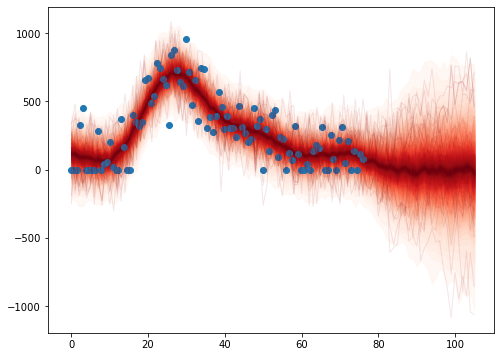

In [44]:
from pymc3.gp.util import plot_gp_dist

fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_samples['expnorm_deaths_pred2'], X_pred)

ax.scatter(X_train2, y_train2)

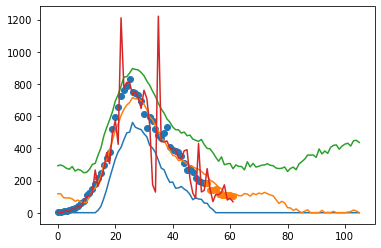

In [45]:
percentiles = [p for p in range(10, 100, 10)]
quantile_gp = [np.percentile(gp_samples['expnorm_deaths_pred2'], q, axis=0) for q in percentiles]
quantile_gp = np.array(quantile_gp)

quantile_gp[quantile_gp < 0] = 0

plt.plot(X_pred, quantile_gp[0])
plt.plot(X_pred, quantile_gp[4])
plt.plot(X_pred, quantile_gp[8])
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

# plt.plot(X_train2, y_train2)
y = deaths
x = np.arange(0, y.shape[0])
plt.plot(x, y)
# plt.xlim(50, 70)
# plt.ylim(-50, 250)

# SARIMAX Residual correction

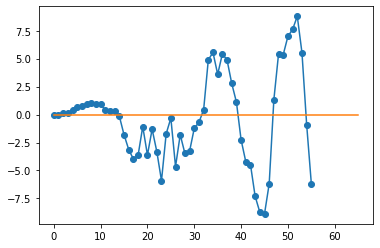

In [352]:
y = residuals
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o')

y = np.zeros(y.shape[0] + 10)
x = np.arange(0, y.shape[0])
plt.plot(x, y)

In [949]:
val_steps = 20

In [950]:
train = residuals[:-val_steps]
test = residuals[-val_steps:]

orig_mse = np.sum(test*test) / test.shape[0]
print(orig_mse)

1987.041149846485


In [954]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, seasonal_order=(2, 0, 1, 3))
model = model.fit()
predictions = model.forecast(val_steps)
print(predictions)
history = np.concatenate([train, predictions])

[ 2.81329101e+00  3.51062568e-01 -2.11301548e-01 -4.52112762e-01
 -2.37580852e-01  1.09998197e-02  1.35845977e-01  4.24536508e-02
 -6.95661214e-03 -3.07262979e-02 -1.20677099e-02  1.26200920e-03
  7.80971179e-03  2.78805653e-03 -3.56031969e-04 -1.88761521e-03
 -7.02010601e-04  8.24993213e-05  4.66051584e-04  1.70344764e-04]


In [955]:
predictions = np.array(predictions)
mse = np.sum((predictions - test)**2) / predictions.shape[0]
print(f'mse: {mse}')
print(f'improvement: {orig_mse - mse}')

mse: 1984.6803616314348
improvement: 2.3607882150502064


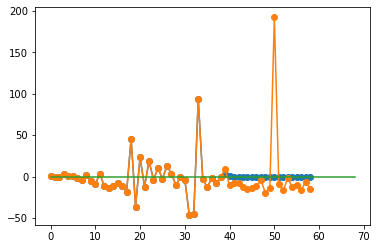

In [956]:
y = np.array(history)
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o')

y = residuals
x = np.arange(0, y.shape[0])
plt.plot(x, y, marker='o')

y = np.zeros(y.shape[0] + 10)
x = np.arange(0, y.shape[0])
plt.plot(x, y)

In [958]:
series = residuals[:-val_steps]

In [959]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

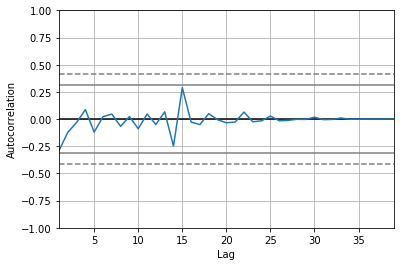

In [960]:
s = pd.Series(series)
autocorrelation_plot(s)

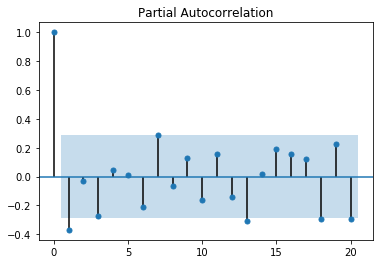

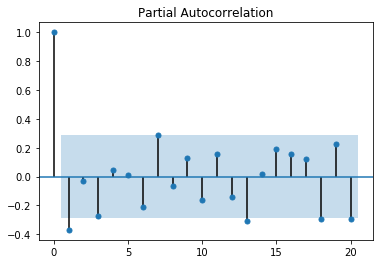

In [863]:
plot_pacf(s, lags=20)